# Stroke pathway timing distribution

## Aims

Visualise distributions of timings for:

* Onset to arrival (when known)
* Arrival to scan
* Scan to needle

Find best distribution fit for the above.

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.preprocessing import StandardScaler

# Hide warnings to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Import data

In [2]:
# import data
raw_data = pd.read_csv(
    './../data/2019-11-04-HQIP303-Exeter_MA.csv', low_memory=False)

## Plot distributions

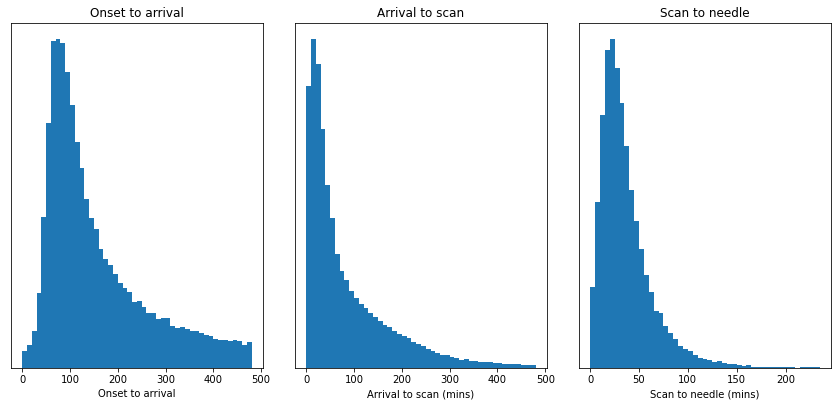

In [3]:
# Set up figure
fig = plt.figure(figsize=(12,6))

# Subplot 1: Histogram of onset to arrival

onset_to_arrival = raw_data['S1OnsetToArrival_min']
# Limit to arrivals within 8 hours
mask = onset_to_arrival <= 480
onset_to_arrival = onset_to_arrival[mask]

ax1 = fig.add_subplot(131)
bins = np.arange(0, 481, 10)
ax1.hist(onset_to_arrival, bins=bins, rwidth=1.0)
ax1.set_xlabel('Onset to arrival')
ax1.set_ylabel('Count')
ax1.set_title('Onset to arrival')
ax1.axes.get_yaxis().set_visible(False)


# Subplot 2: Histogram of arrival to scan

arrival_to_scan = raw_data['S2BrainImagingTime_min']
# Limit to arrivals within 4 hours
mask = arrival_to_scan <= 480
arrival_to_scan = arrival_to_scan[mask]

ax2 = fig.add_subplot(132)
bins = np.arange(0, 481, 10)
ax2.hist(arrival_to_scan, bins=bins, rwidth=1)
ax2.set_xlabel('Arrival to scan (mins)')
ax2.set_ylabel('Count')
ax2.set_title('Arrival to scan')
ax2.axes.get_yaxis().set_visible(False)

# Subplot 2: Histogram of scan to needle

scan_to_needle = \
    raw_data['S2ThrombolysisTime_min'] - raw_data['S2BrainImagingTime_min']

ax3 = fig.add_subplot(133)
bins = np.arange(0, 240, 5)
ax3.hist(scan_to_needle, bins=bins, rwidth=1)
ax3.set_xlabel('Scan to needle (mins)')
ax3.set_ylabel('Count')
ax3.set_title('Scan to needle')
ax3.axes.get_yaxis().set_visible(False)


# Save and show
plt.tight_layout(pad=2)
plt.savefig('output/pathway_distribution.jpg', dpi=300)
plt.show();

## Fit distributions

Distributions are fitted to bootstrapped 10k samples of the data.

### Define function to fit distributions

In [4]:
def fit_distributions(
        data_to_fit, name, number_of_dist_to_plot=1, samples=10000):   
    
    # Reshape data and remove invalid values
    yy = data_to_fit.values
    mask = (yy > 0) & (yy < np.inf)
    yy = yy[mask]
    
    # Bootstrap sample
    yy = np.random.choice(yy, samples, replace=True)
    
    # Reshape
    yy = yy.reshape (-1,1)
    size = len(yy)
    
    # Standardise data
    sc = StandardScaler()
    sc.fit(yy)
    y_std = sc.transform(yy)
    
    # Add +/- 0.0001 Std Dev jitter to avoid failure of fit for discrete data
    jitter = np.random.uniform(-0.0001, 0.0001, samples)
    jitter = jitter.reshape (-1,1)
    y_std += jitter
    
    # Test 10 distributions
    dist_names = ['beta',
              'expon',
              'gamma',
              'lognorm',
              'norm',
              'pearson3',
              'triang',
              'uniform',
              'weibull_min', 
              'weibull_max']
    
    # Set up empty lists to stroe results
    chi_square = []
    p_values = []
    
    # Set up 50 bins for chi-square test
    # Observed data will be approximately evenly distrubuted aross all bins
    percentile_bins = np.linspace(0,100,51)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)
    
    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(y_std, distribution, args=param)[1]
        p = np.around(p, 5)
        p_values.append(p)    

        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # calculate chi-squared
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / 
                  cum_observed_frequency)
        chi_square.append(ss)
        
        # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    results.sort_values(['chi_square'], inplace=True)
    
    # Report results

    print ('\nDistributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)
    print ()

    # Plot
    # ----
    
    # Create figure
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = y_std.copy()
    data = list(data.flatten())
    data.sort()
    
    # Get the top three distributions from the previous phase
    dist_names = results['Distribution'].iloc[0:number_of_dist_to_plot]
    
    # Histograms
    
    # Divide the observed data into 100 bins for plotting (this can be changed)
    number_of_bins = 100
    bin_cutoffs = np.linspace(
        np.percentile(data,0), np.percentile(data,99),number_of_bins)
    
    h = ax1.hist(data, bins = bin_cutoffs, color='0.75')
    x = h[1] # X values for hisotgram
    
            
    for distribution in dist_names:
        
        # Create an empty list to stroe fitted distribution parameters
        parameters = []

        # Set up distribution and store distribution paraemters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(data)
        parameters.append(param)
        
        # Get line for each distribution (and scale to match observed data)
        pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
        scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
        pdf_fitted *= scale_pdf
        
        # Add a small amounbt of jitter to avoid overlying lines
        jitter = np.random.uniform(0.99, 1.01, len(pdf_fitted))
        pdf_fitted *= jitter
        
        # Add the line to the plot
        ax1.plot(x, pdf_fitted, label=distribution, alpha=1)

    ax1.set_xlabel('Normalised value')
    ax1.set_ylabel('Frequency')    
    ax1.set_title('Hisotgram of normalised values')
    ax1.set_ylim(0, np.max(h[0]) * 1.05)
    ax1.legend()          


    for distribution in dist_names:
        # Set up distribution
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        # Get random numbers from distribution
        norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
        norm.sort()

        # Calculate cumulative distributions
        bins = np.percentile(norm,range(0,101))
        data_counts, bins = np.histogram(data,bins)
        norm_counts, bins = np.histogram(norm,bins)
        cum_data = np.cumsum(data_counts)
        cum_norm = np.cumsum(norm_counts)
        cum_data = cum_data / max(cum_data)
        cum_norm = cum_norm / max(cum_norm)

        # plot observed and theoretical distributions
        ax2.plot(cum_norm,cum_data,"o", label=distribution, alpha=0.5)
        
    ax2.set_title('P-P plot')
    ax2.set_xlabel('Theoretical cumulative distribution')
    ax2.set_ylabel('Observed cumulative distribution')
    ax2.legend()
        
    ax2.plot([0,1],[0,1],'r--')

    # Display plot
    plt.tight_layout(pad=2)
    plt.savefig(f'output/pp_{name}.jpg', dpi=300)
    plt.show() 
    
    return

### Fit distributions to onset-to-arrival


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
3      lognorm   1034.321737      0.0
2        gamma   2917.079629      0.0
5     pearson3   2917.203030      0.0
9  weibull_max   4644.417595      0.0
8  weibull_min   5701.372611      0.0
6       triang   9278.524343      0.0
4         norm  19139.495446      0.0
7      uniform  37631.869004      0.0
1        expon  54491.538960      0.0
0         beta  74890.233216      0.0



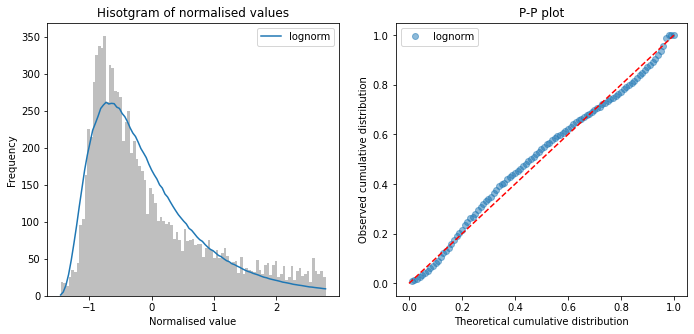

In [5]:
onset_to_arrival = raw_data['S1OnsetToArrival_min']
# Censor at 8 hours
mask = onset_to_arrival <= 480
onset_to_arrival = onset_to_arrival[mask]
fit_distributions(onset_to_arrival, 'onset_to_arrival')

### Fit distributions to arrival-to-scan


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm     933.002052      0.0
2        gamma    1375.265685      0.0
1        expon    1614.298000      0.0
8  weibull_min    3805.073497      0.0
5     pearson3    4033.523243      0.0
0         beta    4300.853464      0.0
9  weibull_max   24046.486663      0.0
6       triang   56773.671137      0.0
4         norm   57794.503988      0.0
7      uniform  113670.959163      0.0



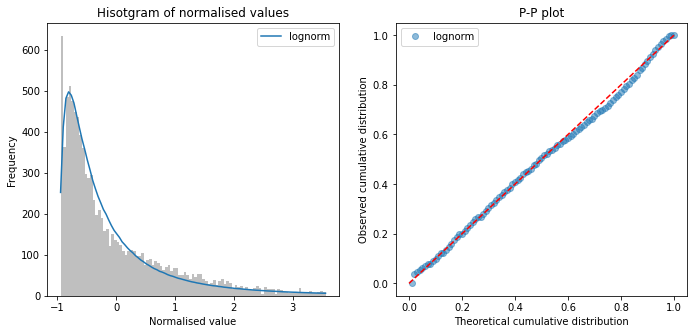

In [6]:
arrival_to_scan = raw_data['S2BrainImagingTime_min']
# Censor at 8 hours
mask = arrival_to_scan <= 480
arrival_to_scan = arrival_to_scan[mask]
fit_distributions(arrival_to_scan, 'arrival_to_scan')

### Fit distributions to scan-to-needle


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
3      lognorm      83.851418      0.0
5     pearson3     597.009581      0.0
0         beta     709.852648      0.0
8  weibull_min    2818.250389      0.0
9  weibull_max    7134.133387      0.0
1        expon   24249.722762      0.0
4         norm   28889.660154      0.0
6       triang  166415.411353      0.0
7      uniform  196113.730283      0.0
2        gamma  835317.187731      0.0



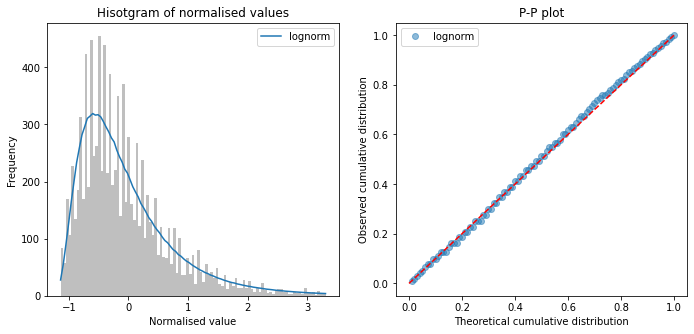

In [7]:
scan_to_needle = \
    raw_data['S2ThrombolysisTime_min'] - raw_data['S2BrainImagingTime_min']
fit_distributions(scan_to_needle, 'scan_to_needle')

## Observations

* All timings show a right skew, with lognormal having minimum chi-squared
* No distribution was a perfect fit to data (all had P<0.01)
* Choose log normal distributions for pathway process times